In [2]:
source('utils.r')
source('selinf_functions.r')
source('metrics.r')
source('data_generator.r')
source('cov_matrix.r')
library('lmmlasso')

## Simulating random time
In this example we simulate data from a certain number of subjects and assume that time (introduced as a dummy variable) has a random effect. We assume that the fixed effect of timem is an important variable, and we don't include it in the penalization. We also try and estimate the variance-covariance matrix by using only the random components, or also including the fixed effect of time, and see if there are differences in the power results (TPR and average length of CIs).

In [3]:
set.seed(1)

n_subjects= 25
n_observations = 4
n = n_subjects * n_observations
p = 100
q <- n_observations-1
SNR = 4
prop_relevant = 0.1

data <- data_generator_random_time(n_subjects, n_observations, p, SNR, prop_relevant, rho=0.5)
X <- data$X
Z <- data$Z
subjects <- data$subjects
y <- data$y
beta <- data$beta
sd <- data$sd

Warning message in cov2cor(Psi):
"diag(.) had 0 or NA entries; non-finite result is doubtful"


Redundant covariance parameters. 


Warning message in cov2cor(Psi):
"diag(.) had 0 or NA entries; non-finite result is doubtful"


Redundant covariance parameters. 
|activeSet|>=min(p,ntot): Increase lambda or set stopSat=FALSE. 
[1] 13.58506


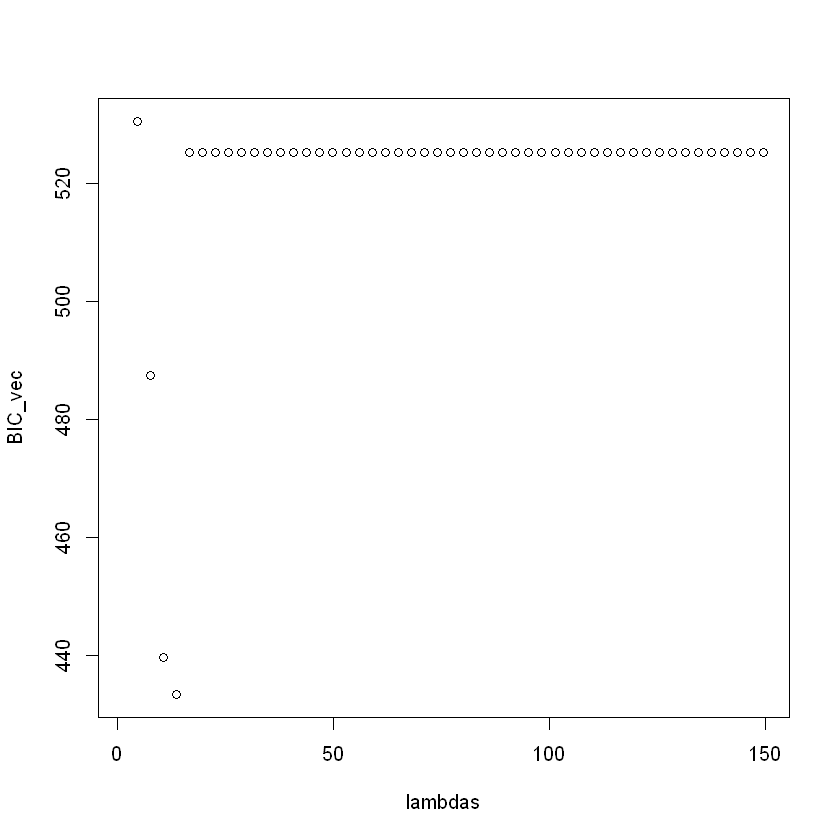

In [41]:
lambda.max.min.ratio = 0.01
n_lambdas = 50
lambda_max <- max(abs(t(X) %*% y))
plotting = TRUE
lambdas <- linspace(lambda_max,lambda_max*lambda.max.min.ratio, n=n_lambdas)
BIC_vec<-rep(Inf,length(lambdas))

for(j in 1:length(lambdas))
{

lasso_res <- lmmlasso(cbind(rep(1,n),X),y,cbind(rep(1,n),Z),subjects,lambda=lambdas[j],nonpen = c(1:4))
BIC_vec[j]<-lasso_res$bic
}

if(plotting) plot(lambdas,BIC_vec)

opt<-which.min(BIC_vec)

print(lambdas[opt])

lasso_res <- lmmlasso(cbind(rep(1,n),X),y,cbind(rep(1,n),Z),subjects,lambda=lambdas[opt],nonpen = c(1:4))